In [1]:
import pandas as pd
import time, datetime, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle, utils, tools, plots, lmfit

plt.style.use("style.mplstyle")
path_to_save_plots = "/eos/user/j/jcapotor/DUNE-IFIC/Academic/PhD_Thesis/The Temperature Monitoring System for DUNE and its prototypes at CERN/Contents/PDHD/PDHD_OPERATION/pictures/NORMAL_OPERATION/"

In [2]:
tini, tend = datetime.datetime(2024, 7, 1, 0, 0, 0), datetime.datetime(2024, 7, 6, 0, 0, 0)
data, data_err = utils.load_data(tini, tend)

Text(0.5, 1.0, 'NP04 Temperature Evolution')

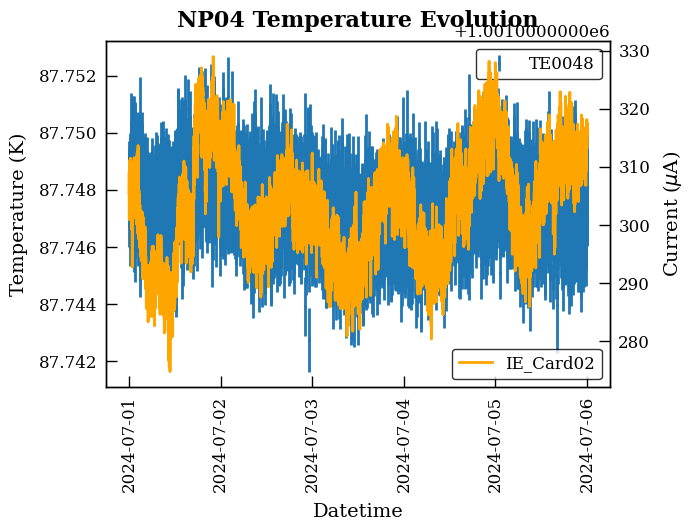

In [3]:
fig, axes = plt.subplots(1, 1)

plots.plot_temp_evolution(
    data=data, data_err=data_err, channel="TE0048",
    tmax=300, tmax_err=1,
    axes=axes
)
#axes.axvline(datetime.datetime(2024, 5, 3, 13, 30, 0), label="Recirculation ON", color="red")
#axes.axvline(datetime.datetime(2024, 12, 3, 14, 30, 0), label="Recirculation ON", color="orange")
axes2 = axes.twinx()
axes2.plot(data.index.to_numpy(), 1e6*data["IE_Card02"].to_numpy(), color="orange", label="IE_Card02")
axes.legend()
axes2.legend()
axes.set_xlabel("Datetime")
axes.set_ylabel("Temperature (K)")
axes2.set_ylabel("Current ($\mu$A)")
axes.set_title("NP04 Temperature Evolution")
# fig.savefig(f"{path_to_save_plots}np04_temp_evolution_TE0001.png", format="png")

In [4]:
def line(x, A, B):
    return A + B * x

results = {}
minchi2 = 1e10

sample = list(range(10, 240 + 1, 5))
for minutes in sample:
    i = 48
    try:
        data_plot = data.resample(f"{minutes}min").mean()
        data_plot_err = data.resample(f"{minutes}min").std()
        line_model = lmfit.Model(line)
        params = line_model.make_params(A=0, B=1)
        weights = 1 / np.sqrt(data_plot_err["IE_Card02"].to_numpy()**2 + data_plot_err[fr"TE00{i}"].to_numpy()**2)
        fit_result = line_model.fit((data_plot[fr"TE00{i}"]-data_plot[fr"TE00{i}"].iloc[0]).to_numpy(),
                                    params,
                                    x=data_plot["IE_Card02"].to_numpy(), weights=weights)
        if fit_result.redchi > 0.5:
            continue
        results[minutes] = {"redchi":fit_result.redchi, "A":fit_result.params["A"].value, "B":fit_result.params["B"].value, "B_err":fit_result.params["B"].stderr}
        if fit_result.redchi < minchi2:
            minchi2 = fit_result.redchi
            best_minutes = minutes
    except:
        continue
results = pd.DataFrame(results).T
print(results.columns)

Index(['redchi', 'A', 'B', 'B_err'], dtype='object')


Text(0.5, 1.0, 'Slope of the Temperature vs Current: Linear Fit')

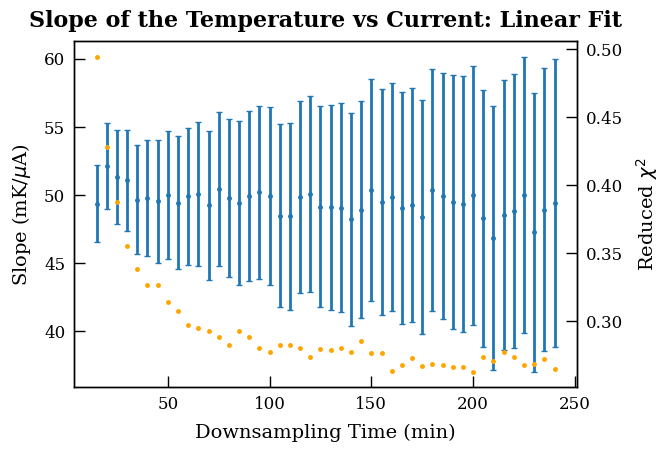

In [5]:
fig, axes = plt.subplots(1,1)
axes2 = axes.twinx()
axes.errorbar(results.index.to_numpy(), results["B"].to_numpy(), yerr=results["B_err"].to_numpy(), fmt="o", capsize=2)
axes2.plot(results.index.to_numpy(), results["redchi"].to_numpy(), "o", color="orange")
axes2.set_ylabel("Reduced $\chi^2$")
axes.set_ylabel(r"Slope (mK/$\mu$A)")
axes.set_xlabel("Downsampling Time (min)")
axes.set_title("Slope of the Temperature vs Current: Linear Fit")

In [6]:
mapping = utils.load_mapping(date=datetime.datetime(2024, 7, 1, 0, 0, 0))
sampling_time = 120
data_plot = data.resample(f"{sampling_time}min").mean()
data_plot_err = data.resample(f"{sampling_time}min").std()
slopes = {}
chan_board = {}
for index, row in mapping.iterrows():
    channel = row["SC-ID"]
    if row["SYSTEM"] == "PIPE" and "I" in row["NAME"]:
        continue
    try:
        int(row["BOARD"])
    except:
        continue
    if int(row["BOARD"]) > 4:
        continue
    try:
        current_channel = f'IE_Card0{int(row["BOARD"])}'
        line_model = lmfit.Model(line)
        params = line_model.make_params(A=0, B=1)
        weights = 1 / np.sqrt(data_plot_err[current_channel].to_numpy()**2 + data_plot_err[channel].to_numpy()**2)
        fit_result = line_model.fit((data_plot[channel]).to_numpy(),
                                    params,
                                    x=data_plot[current_channel].to_numpy(), weights=weights)
        if fit_result.redchi > 0.5:
            continue
        slopes[channel] = {"slope":fit_result.params["B"].value, "slope_err":fit_result.params["B"].stderr,
                           "T0":fit_result.params["A"].value, "T0_err":fit_result.params["A"].stderr,
                           "board":int(row["BOARD"]), "current_channel":current_channel}
        if current_channel not in chan_board:
            chan_board[current_channel] = []
        chan_board[current_channel].append(channel)
    except:
        continue
slopes = pd.DataFrame(slopes).T

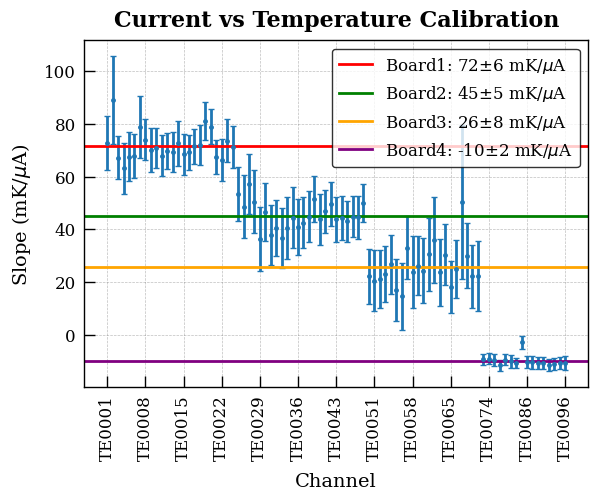

In [7]:
plt.errorbar(slopes.index.to_numpy(), slopes["slope"].to_numpy(), yerr=slopes["slope_err"].to_numpy(), fmt="o", capsize=2)
plt.ylabel(r"Slope (mK/$\mu$A)")
plt.xlabel("Channel")
xticks = slopes.index.to_numpy()
plt.xticks(xticks[::max(1, len(xticks)//11)], rotation=90)
plt.grid("on")
plt.title("Current vs Temperature Calibration")

board1 = slopes.loc[chan_board["IE_Card01"]]
plt.axhline(board1["slope"].mean(), color="red", label=fr'Board1: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
board1 = slopes.loc[chan_board["IE_Card02"]]
plt.axhline(board1["slope"].mean(), color="green", label=fr'Board2: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
board1 = slopes.loc[chan_board["IE_Card03"]]
plt.axhline(board1["slope"].mean(), color="orange", label=fr'Board3: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
board1 = slopes.loc[chan_board["IE_Card04"]]
plt.axhline(board1["slope"].mean(), color="purple", label=fr'Board4: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
plt.legend()

slopes.to_csv("/eos/user/j/jcapotor/DUNE-IFIC/Experiments/ProtoDUNE-HD/Operation/Data/2024-7-1_2024-7-6_current_correction.csv")

Text(0.5, 1.0, 'Current vs Temperature Calibration')

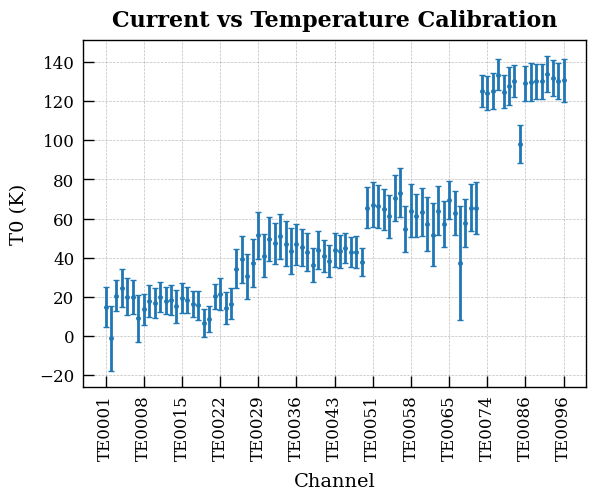

In [8]:
plt.errorbar(slopes.index.to_numpy(), slopes["T0"].to_numpy(), yerr=slopes["T0_err"].to_numpy(), fmt="o", capsize=2)
plt.ylabel(r"T0 (K)")
plt.xlabel("Channel")
xticks = slopes.index.to_numpy()
plt.xticks(xticks[::max(1, len(xticks)//11)], rotation=90)
plt.grid("on")
plt.title("Current vs Temperature Calibration")

In [49]:
tini, tend = datetime.datetime(2024, 8, 10, 0, 0, 0), datetime.datetime(2024, 8, 15, 0, 0, 0)
data, data_err = utils.load_data(tini, tend)

Text(0.5, 1.0, 'NP04 Temperature Evolution')

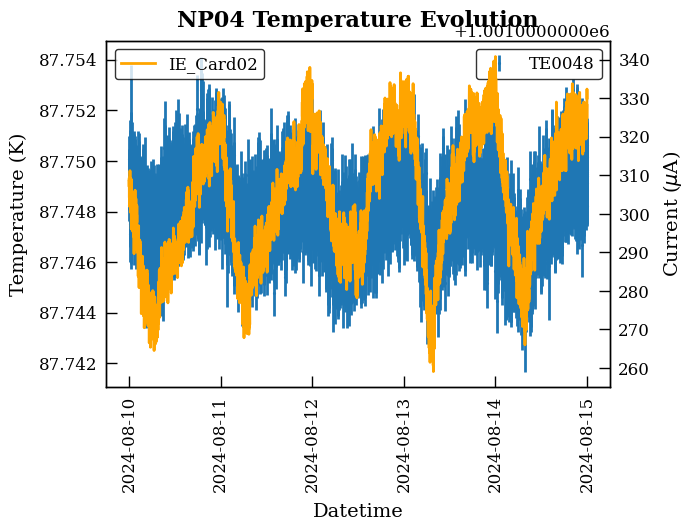

In [50]:
fig, axes = plt.subplots(1, 1)

plots.plot_temp_evolution(
    data=data, data_err=data_err, channel="TE0048",
    tmax=300, tmax_err=1,
    axes=axes
)
#axes.axvline(datetime.datetime(2024, 5, 3, 13, 30, 0), label="Recirculation ON", color="red")
#axes.axvline(datetime.datetime(2024, 12, 3, 14, 30, 0), label="Recirculation ON", color="orange")
axes2 = axes.twinx()
axes2.plot(data.index.to_numpy(), 1e6*data["IE_Card02"].to_numpy(), color="orange", label="IE_Card02")
axes.legend()
axes2.legend()
axes.set_xlabel("Datetime")
axes.set_ylabel("Temperature (K)")
axes2.set_ylabel("Current ($\mu$A)")
axes.set_title("NP04 Temperature Evolution")
# fig.savefig(f"{path_to_save_plots}np04_temp_evolution_TE0001.png", format="png")

In [51]:
def line(x, A, B):
    return A + B * x

results = {}
minchi2 = 1e10

sample = list(range(10, 240 + 1, 5))
for minutes in sample:
    i = 48
    try:
        data_plot = data.resample(f"{minutes}min").mean()
        data_plot_err = data.resample(f"{minutes}min").std()
        line_model = lmfit.Model(line)
        params = line_model.make_params(A=0, B=1)
        weights = 1 / np.sqrt(data_plot_err["IE_Card02"].to_numpy()**2 + data_plot_err[fr"TE00{i}"].to_numpy()**2)
        fit_result = line_model.fit((data_plot[fr"TE00{i}"]-data_plot[fr"TE00{i}"].iloc[0]).to_numpy(),
                                    params,
                                    x=data_plot["IE_Card02"].to_numpy(), weights=weights)
        if fit_result.redchi > 0.5:
            continue
        results[minutes] = {"redchi":fit_result.redchi, "A":fit_result.params["A"].value, "B":fit_result.params["B"].value, "B_err":fit_result.params["B"].stderr}
        if fit_result.redchi < minchi2:
            minchi2 = fit_result.redchi
            best_minutes = minutes
    except:
        continue
results = pd.DataFrame(results).T
print(results.columns)

Index(['redchi', 'A', 'B', 'B_err'], dtype='object')


In [52]:
mapping = utils.load_mapping(date=datetime.datetime(2024, 11, 2, 0, 0, 0))
sampling_time = 120
data_plot = data.resample(f"{sampling_time}min").mean()
data_plot_err = data.resample(f"{sampling_time}min").std()
slopes = {}
chan_board = {}
for index, row in mapping.iterrows():
    channel = row["SC-ID"]
    if channel == "TE0067":
        continue
    if row["SYSTEM"] == "PIPE" and "I" in row["NAME"]:
        continue
    try:
        int(row["BOARD"])
    except:
        continue
    if int(row["BOARD"]) > 4:
        continue
    try:
        current_channel = f'IE_Card0{int(row["BOARD"])}'
        line_model = lmfit.Model(line)
        params = line_model.make_params(A=0, B=1)
        weights = 1 / np.sqrt(data_plot_err[current_channel].to_numpy()**2 + data_plot_err[channel].to_numpy()**2)
        fit_result = line_model.fit((data_plot[channel]).to_numpy(),
                                    params,
                                    x=data_plot[current_channel].to_numpy(), weights=weights)
        if fit_result.redchi > 0.5:
            continue
        slopes[channel] = {"slope":fit_result.params["B"].value, "slope_err":fit_result.params["B"].stderr,
                           "T0":fit_result.params["A"].value, "T0_err":fit_result.params["A"].stderr,
                           "board":int(row["BOARD"]), "current_channel":current_channel}
        if current_channel not in chan_board:
            chan_board[current_channel] = []
        chan_board[current_channel].append(channel)
    except:
        continue
slopes = pd.DataFrame(slopes).T

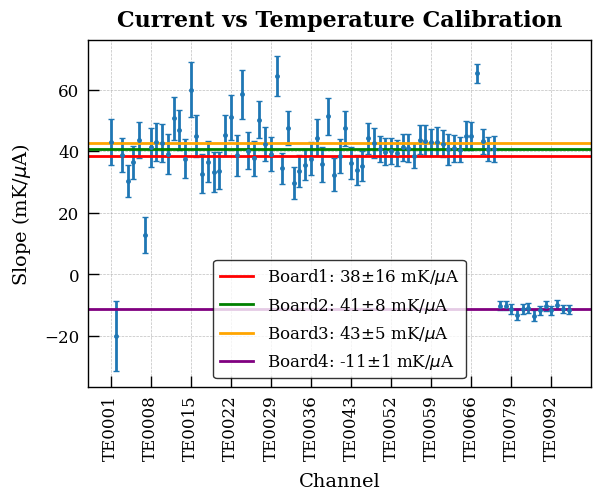

In [53]:
plt.errorbar(slopes.index.to_numpy(), slopes["slope"].to_numpy(), yerr=slopes["slope_err"].to_numpy(), fmt="o", capsize=2)
plt.ylabel(r"Slope (mK/$\mu$A)")
plt.xlabel("Channel")
xticks = slopes.index.to_numpy()
plt.xticks(xticks[::max(1, len(xticks)//11)], rotation=90)
plt.grid("on")
plt.title("Current vs Temperature Calibration")

board1 = slopes.loc[chan_board["IE_Card01"]]
plt.axhline(board1["slope"].mean(), color="red", label=fr'Board1: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
board1 = slopes.loc[chan_board["IE_Card02"]]
plt.axhline(board1["slope"].mean(), color="green", label=fr'Board2: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
board1 = slopes.loc[chan_board["IE_Card03"]]
plt.axhline(board1["slope"].mean(), color="orange", label=fr'Board3: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
board1 = slopes.loc[chan_board["IE_Card04"]]
plt.axhline(board1["slope"].mean(), color="purple", label=fr'Board4: {board1["slope"].mean():.0f}$\pm${board1["slope"].std():.0f} mK/$\mu$A')
plt.legend()

slopes.to_csv("/eos/user/j/jcapotor/DUNE-IFIC/Experiments/ProtoDUNE-HD/Operation/Data/2024-7-1_2024-7-6_current_correction.csv")